# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from statsmodels.tsa.stattools import grangercausalitytests, coint, adfuller, acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#import data 
df = pd.read_csv("/home/fraia/Arduino/Predictive Model/data_cl/home_data_cl_21_03.csv")

In [3]:
display(df)
display(df.info())

,Unnamed: 0,id,timestamp,sense_hum,sense_temp,open_hum,open_temp,pressure,water_temp
0,3,4,2024-02-21 09:24:31,40.8,21.9,70.0,6.74,1027.0,30.0
1,4,5,2024-02-21 09:29:39,41.5,21.7,71.0,6.81,1028.0,30.0
2,5,6,2024-02-21 09:34:45,41.8,21.6,68.0,7.30,1028.0,30.0
3,6,6,2024-02-21 09:34:45,41.8,21.6,68.0,7.30,1028.0,29.0
4,7,7,2024-02-21 09:39:52,42.0,21.6,68.0,7.30,1028.0,29.0
...,...,...,...,...,...,...,...,...,...
3888,3891,3448,2024-03-05 07:18:29,38.0,22.1,67.0,5.56,1022.0,30.0
3889,3892,3449,2024-03-05 07:23:35,38.1,22.1,67.0,5.56,1022.0,30.0
3890,3893,3450,2024-03-05 07:28:42,38.0,22.0,67.0,5.56,1022.0,30.0
3891,3894,3451,2024-03-05 07:33:48,38.0,22.1,66.0,5.58,1022.0,30.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3893 non-null   int64  
 1   id          3893 non-null   int64  
 2   timestamp   3893 non-null   object 
 3   sense_hum   3893 non-null   float64
 4   sense_temp  3893 non-null   float64
 5   open_hum    3893 non-null   float64
 6   open_temp   3893 non-null   float64
 7   pressure    3893 non-null   float64
 8   water_temp  3893 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 273.9+ KB


None

### Check for non-valid values

In [4]:
#NAN
display("Nan values:", df.isna().sum())
display("Duplicated values: ",df.duplicated().sum())

'Nan values:'

Unnamed: 0    0
id            0
timestamp     0
sense_hum     0
sense_temp    0
open_hum      0
open_temp     0
pressure      0
water_temp    0
dtype: int64

'Duplicated values: '

0

In [5]:
df_cl = df
df_cl = df_cl.iloc[3:]

#Deal with non-valid values from gauge data by replacing NAN values with the mean 
def replace_nan_with_mean(series):
    nan_indices = series.index[series.isna()]  # Get indices of NaN values
    for idx in nan_indices:
        # Search for the nearest non-NaN value above the current index
        above_idx = idx
        while above_idx in nan_indices:
            above_idx -= 1
        if above_idx < 0:  # If no non-NaN value above, take the first non-NaN value below
            above_idx = idx + 1
        
        # Search for the nearest non-NaN value below the current index
        below_idx = idx
        while below_idx in nan_indices:
            below_idx += 1
        if below_idx >= len(series):  # If no non-NaN value below, take the last non-NaN value above
            below_idx = idx - 1
        
        above_val = series.loc[above_idx]
        below_val = series.loc[below_idx]
        
        mean_val = (above_val + below_val) / 2
        series.at[idx] = mean_val
replace_nan_with_mean(df_cl["water_temp"])

df_cl.shape

(3890, 9)

In [6]:
df_cl.shape

(3890, 9)

In [7]:
#turn timestamp into datetime object and index 
#remove id

df_cl["timestamp"] = pd.to_datetime(df["timestamp"])
df_cl = df_cl.set_index("timestamp")

df_cl = df_cl.drop(columns="id", axis=1)

/tmp/ipykernel_10963/1385775017.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cl["timestamp"] = pd.to_datetime(df["timestamp"])


## Explore Variables

<Axes: >

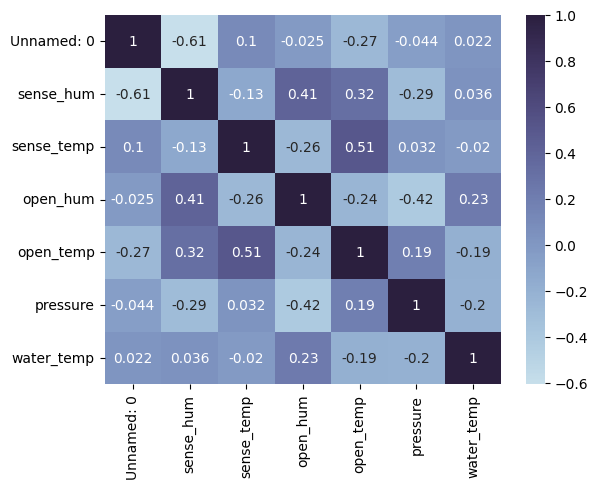

In [8]:
#Check for multicollinearity
correlation = df_cl.corr()
sns.heatmap(correlation, annot=True, cmap=sns.color_palette('ch:s=.25,rot=-.25', as_cmap=True))
#no multicollinearity found

### Temperature

In [9]:
df_temp = pd.DataFrame(df_cl["sense_temp"])

#Is it stationary?
adf, p_value, usedlag_, nobs_, criticalvalues_, icbest_ = adfuller(df_temp)
print("p_value:", p_value, "\nIf above 0.05 data is not stationary") #stationary: mean and variance don't change over time

p_value: 1.2143193875190536e-06 
If above 0.05 data is not stationary


P-value is below 0.05, thus it is appropriate to say that temperature is clearly stationary, meaning that mean and variance don't change over time. This may be attributed to the small window of time in the dataset

Axes(0.125,0.11;0.352273x0.77)
Axes(0.547727,0.11;0.352273x0.77)


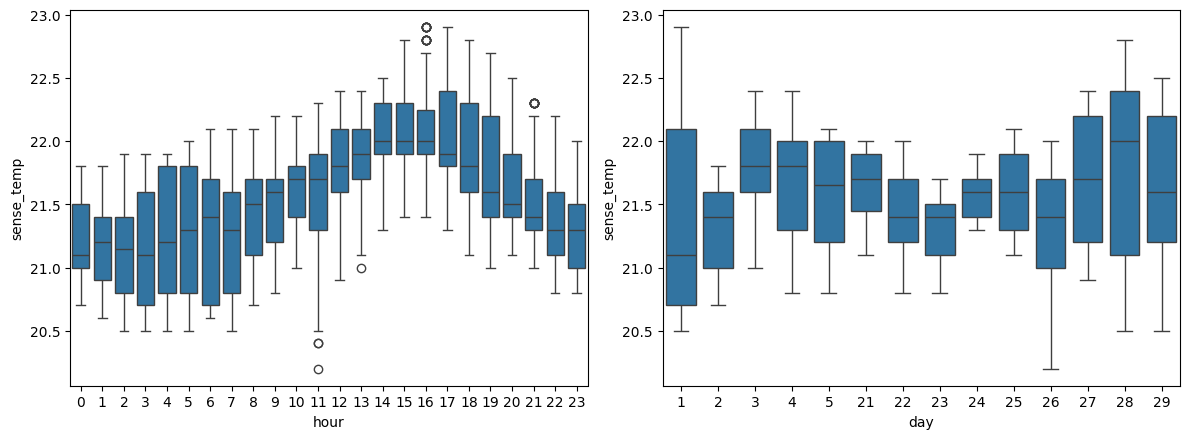

In [10]:
df_temp["hour"] = [d.hour for d in df_temp.index]
df_temp["day"] = [d.day for d in df_temp.index]

plt.rcParams["figure.figsize"] = [12.00, 4.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots(1,2)
print(sns.boxplot(x = "hour", y = "sense_temp", data=df_temp, ax=ax[0]))
print(sns.boxplot(x = "day", y = "sense_temp", data=df_temp, ax=ax[1]))
plt.show()

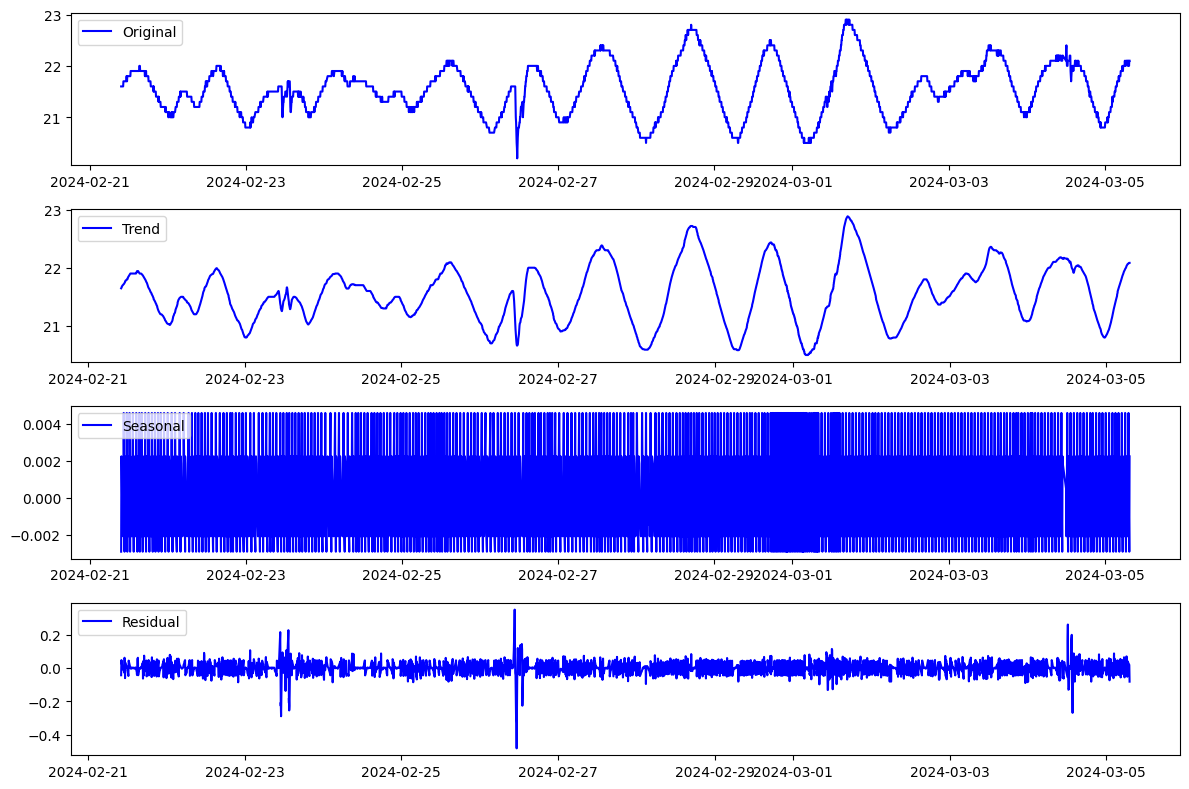

In [11]:
decompose = seasonal_decompose(df_temp["sense_temp"], model = "additive", period=12)

trend = decompose.trend
seasonal = decompose.seasonal #original minus the trend
residual = decompose.resid #whatever is remaining

plt.figure(figsize= (12, 8))
plt.subplot(411)
plt.plot(df_temp["sense_temp"], label = "Original", color = "blue")
plt.legend(loc = "upper left")
plt.subplot(412)
plt.plot(trend, label = "Trend", color = "blue")
plt.legend(loc = "upper left")
plt.subplot(413)
plt.plot(seasonal, label = "Seasonal", color = "blue")
plt.legend(loc = "upper left")
plt.subplot(414)
plt.plot(residual, label = "Residual", color = "blue")
plt.legend(loc = "upper left")

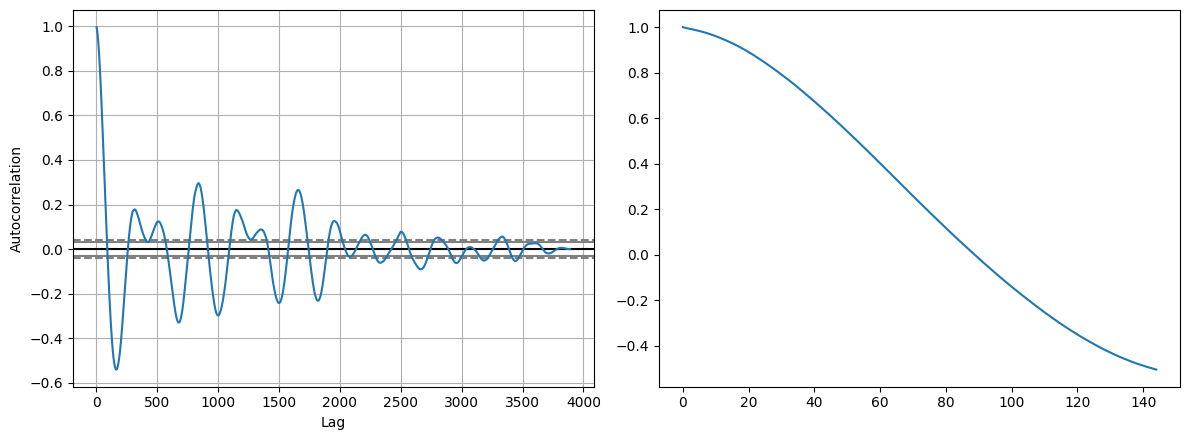

In [12]:
from pandas.plotting import autocorrelation_plot

fig, ax = plt.subplots(1, 2)
autocorrelation_plot(df_temp["sense_temp"], ax= ax[0])

#Autocorrelation
acf_144 = acf(df_temp.sense_temp, nlags=144)
ax[1].plot(acf_144)

Any lag below 50 is highly autocorrelated at a 99% confidence level 

### Other Variables

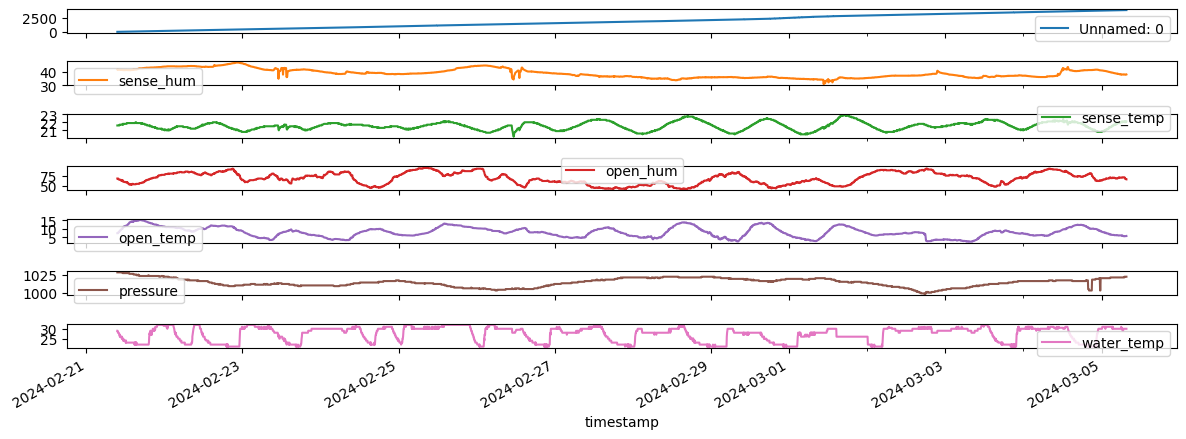

<Figure size 1400x1400 with 0 Axes>

In [13]:
df_cl.plot(subplots=True, layout=(len(df_cl.columns), 1))
plt.figure(figsize=(14, 14))
plt.show()

### Scaling for proper comparison and correlation analysis 

In [14]:
from sklearn.preprocessing import StandardScaler

columns_cl = df_cl.columns

scaler = StandardScaler()
scaler = scaler.fit(df_cl)
df_trans = scaler.transform(df_cl) 
df_trans = pd.DataFrame(df_trans, columns=columns_cl, index=df_cl.index)

### Cointegration with target variable

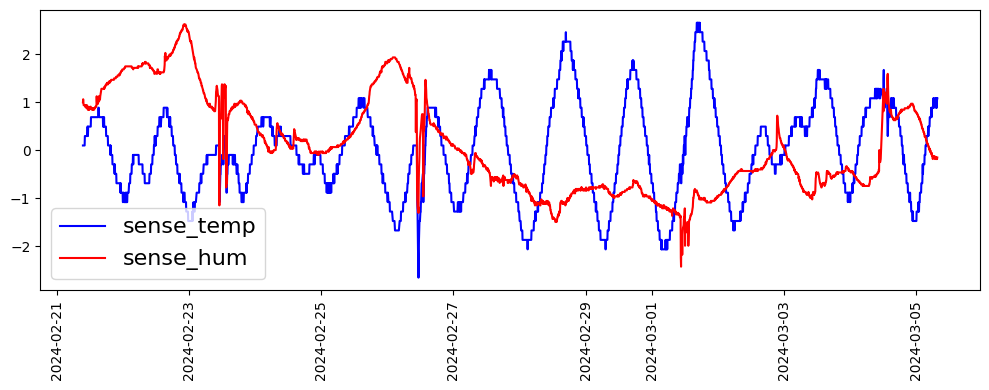

In [15]:
#Indoor temp with indoor humidity 
hum_col = ["sense_temp", "sense_hum"]
df_temp_hum = df_trans[hum_col]

plt.figure(figsize=(10, 4))
plt.plot(df_temp_hum["sense_temp"], color = "blue")
plt.plot(df_temp_hum["sense_hum"], color = "red")

plt.legend(["sense_temp", "sense_hum"], fontsize = 16)
plt.xticks(rotation=90)
plt.show()

In [16]:
t_statistics, p_val, critical_p_val = coint(df_temp_hum["sense_temp"], df_temp_hum["sense_hum"])
print(f"t-statistics: {np.round(t_statistics, 2)} \np_value: {np.round(p_val, 2)} \ncritical p-values [10%, 5%, 1%]: {np.round(critical_p_val, 2)}")

t-statistics: -5.42 
p_value: 0.0 
critical p-values [10%, 5%, 1%]: [-3.9  -3.34 -3.05]


In [17]:
grangercausalitytests(df_temp_hum, 40)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1408  , p=0.2856  , df_denom=3886, df_num=1
ssr based chi2 test:   chi2=1.1416  , p=0.2853  , df=1
likelihood ratio test: chi2=1.1415  , p=0.2853  , df=1
parameter F test:         F=1.1408  , p=0.2856  , df_denom=3886, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=95.0276 , p=0.0000  , df_denom=3883, df_num=2
ssr based chi2 test:   chi2=190.3000, p=0.0000  , df=2
likelihood ratio test: chi2=185.7894, p=0.0000  , df=2
parameter F test:         F=95.0276 , p=0.0000  , df_denom=3883, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=74.7550 , p=0.0000  , df_denom=3880, df_num=3
ssr based chi2 test:   chi2=224.6696, p=0.0000  , df=3
likelihood ratio test: chi2=218.4165, p=0.0000  , df=3
parameter F test:         F=74.7550 , p=0.0000  , df_denom=3880, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=62.6752 , p=0.

{1: ({'ssr_ftest': (1.1407657718037014, 0.28555691820464363, 3886.0, 1),
   'ssr_chi2test': (1.1416464453279964, 0.28530469399445607, 1),
   'lrtest': (1.1414789084883523, 0.28534004349801273, 1),
   'params_ftest': (1.1407657718120843, 0.28555691820299, 3886.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (95.02762131265742, 5.107700743414885e-41, 3883.0, 2),
   'ssr_chi2test': (190.2999699529292, 4.752110947308253e-42, 2),
   'lrtest': (185.78940562910793, 4.5325559067155e-41, 2),
   'params_ftest': (95.02762131266131, 5.107700743395142e-41, 3883.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (74.75500025611532, 5.296739596688428e-47, 3880.0, 3),
   'ssr_chi2test': (224.66960257385583, 1.9644826088861617e-48, 3),
   'lrtest': (218.41645178993713, 4.41598663451709e-47, 3),
   'params_ftest': (74.75500025611439, 5.296739596694449e-47, 3880.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],

High cointegration and most likely not spurious correlation

Both small and large lags seem to be statistically significant. Granger causality is strong from `sense_hum` on `sense_temp` just after the 2nd lag, 10 minutes.


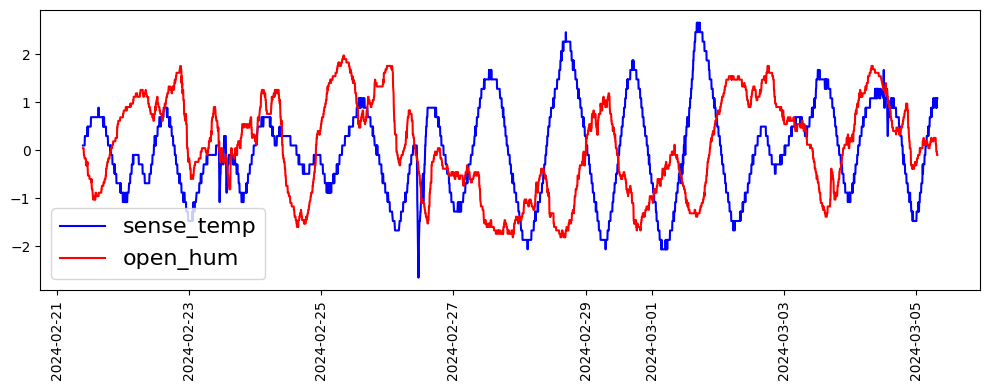

In [18]:
#Indoor temperature with outdoor humidity
open_hum_col = ["sense_temp", "open_hum"]
df_temp_ophum = df_trans[open_hum_col]

plt.figure(figsize=(10, 4))
plt.plot(df_temp_ophum["sense_temp"], color = "blue")
plt.plot(df_temp_ophum["open_hum"], color = "red")

plt.legend(["sense_temp", "open_hum"], fontsize = 16)
plt.xticks(rotation=90)
plt.show()

In [19]:
t_statistics, p_val, critical_p_val = coint(df_temp_ophum["sense_temp"], df_temp_ophum["open_hum"])
print(f"t-statistics: {np.round(t_statistics, 2)} \np_value: {np.round(p_val, 2)} \ncritical p-values [10%, 5%, 1%]: {np.round(critical_p_val, 2)}")

t-statistics: -5.58 
p_value: 0.0 
critical p-values [10%, 5%, 1%]: [-3.9  -3.34 -3.05]


In [20]:
grangercausalitytests(df_temp_ophum, 60, verbose = True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4585  , p=0.2272  , df_denom=3886, df_num=1
ssr based chi2 test:   chi2=1.4596  , p=0.2270  , df=1
likelihood ratio test: chi2=1.4594  , p=0.2270  , df=1
parameter F test:         F=1.4585  , p=0.2272  , df_denom=3886, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8412  , p=0.0585  , df_denom=3883, df_num=2
ssr based chi2 test:   chi2=5.6898  , p=0.0581  , df=2
likelihood ratio test: chi2=5.6856  , p=0.0583  , df=2
parameter F test:         F=2.8412  , p=0.0585  , df_denom=3883, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9021  , p=0.1270  , df_denom=3880, df_num=3
ssr based chi2 test:   chi2=5.7165  , p=0.1262  , df=3
likelihood ratio test: chi2=5.7123  , p=0.1265  , df=3
parameter F test:         F=1.9021  , p=0.1270  , df_denom=3880, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1916  , p=0.

/home/fraia/Arduino/Predictive Model/temppred.env/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=1.3171  , p=0.1421  , df_denom=3820, df_num=23
ssr based chi2 test:   chi2=30.6670 , p=0.1312  , df=23
likelihood ratio test: chi2=30.5460 , p=0.1344  , df=23
parameter F test:         F=1.3171  , p=0.1421  , df_denom=3820, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=1.2906  , p=0.1556  , df_denom=3817, df_num=24
ssr based chi2 test:   chi2=31.3713 , p=0.1434  , df=24
likelihood ratio test: chi2=31.2447 , p=0.1469  , df=24
parameter F test:         F=1.2906  , p=0.1556  , df_denom=3817, df_num=24

Granger Causality
number of lags (no zero) 25
ssr based F test:         F=1.4046  , p=0.0871  , df_denom=3814, df_num=25
ssr based chi2 test:   chi2=35.5856 , p=0.0781  , df=25
likelihood ratio test: chi2=35.4228 , p=0.0808  , df=25
parameter F test:         F=1.4046  , p=0.0871  , df_denom=3814, df_num=25

Granger Causality
number of lags (no zero) 26
ssr based F test:         F=1.4282  , p=0.0737  , df_denom=3811, df_num=2

{1: ({'ssr_ftest': (1.4585152847152438, 0.22723999815894608, 3886.0, 1),
   'ssr_chi2test': (1.4596412615176488, 0.22698720841299663, 1),
   'lrtest': (1.459367409679544, 0.2270307992986688, 1),
   'params_ftest': (1.4585152847221792, 0.2272399981577005, 3886.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.841240468305829, 0.058474558160228146, 3883.0, 2),
   'ssr_chi2test': (5.689798063751256, 0.058140136744032594, 2),
   'lrtest': (5.6856388235064514, 0.0582611719523308, 2),
   'params_ftest': (2.8412404683090884, 0.05847455816003323, 3883.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.902069482888146, 0.12700241614419647, 3880.0, 3),
   'ssr_chi2test': (5.716503154628523, 0.1262477602098361, 3),
   'lrtest': (5.71230372008722, 0.12647775576359993, 3),
   'params_ftest': (1.9020694828879148, 0.12700241614424035, 3880.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0.,

High cointegration and most likely not spurious correlation

There doesn't seem to be any granger causality from `open_hum` on `sense_temp` 

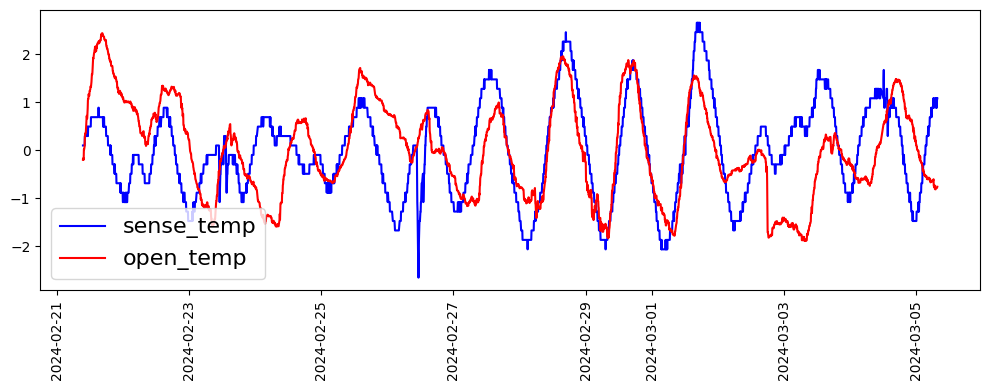

In [21]:
#Indoor temp with outdoor temperature 
temp_col = ["sense_temp", "open_temp"]
df_temp_temp = df_trans[temp_col]

plt.figure(figsize=(10, 4))
plt.plot(df_temp_temp["sense_temp"], color = "blue")
plt.plot(df_temp_temp["open_temp"], color = "red")

plt.legend(["sense_temp", "open_temp"], fontsize = 16)
plt.xticks(rotation=90)
plt.show()

In [22]:
t_statistics, p_val, critical_p_val = coint(df_temp_temp["sense_temp"], df_temp_temp["open_temp"])
print(f"t-statistics: {np.round(t_statistics, 2)} \np_value: {np.round(p_val, 2)} \ncritical p-values [10%, 5%, 1%]: {np.round(critical_p_val, 2)}")

t-statistics: -5.13 
p_value: 0.0 
critical p-values [10%, 5%, 1%]: [-3.9  -3.34 -3.05]


In [23]:
grangercausalitytests(df_temp_temp, 120, verbose = True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2559  , p=0.6130  , df_denom=3886, df_num=1
ssr based chi2 test:   chi2=0.2561  , p=0.6128  , df=1
likelihood ratio test: chi2=0.2561  , p=0.6128  , df=1
parameter F test:         F=0.2559  , p=0.6130  , df_denom=3886, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.9406  , p=0.0000  , df_denom=3883, df_num=2
ssr based chi2 test:   chi2=19.9069 , p=0.0000  , df=2
likelihood ratio test: chi2=19.8561 , p=0.0000  , df=2
parameter F test:         F=9.9406  , p=0.0000  , df_denom=3883, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.5032  , p=0.0000  , df_denom=3880, df_num=3
ssr based chi2 test:   chi2=25.5558 , p=0.0000  , df=3
likelihood ratio test: chi2=25.4721 , p=0.0000  , df=3
parameter F test:         F=8.5032  , p=0.0000  , df_denom=3880, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=9.3209  , p=0.

/home/fraia/Arduino/Predictive Model/temppred.env/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=1.6244  , p=0.0219  , df_denom=3808, df_num=27
ssr based chi2 test:   chi2=44.4917 , p=0.0184  , df=27
likelihood ratio test: chi2=44.2374 , p=0.0195  , df=27
parameter F test:         F=1.6244  , p=0.0219  , df_denom=3808, df_num=27

Granger Causality
number of lags (no zero) 28
ssr based F test:         F=1.5980  , p=0.0240  , df_denom=3805, df_num=28
ssr based chi2 test:   chi2=45.4133 , p=0.0200  , df=28
likelihood ratio test: chi2=45.1484 , p=0.0213  , df=28
parameter F test:         F=1.5980  , p=0.0240  , df_denom=3805, df_num=28

Granger Causality
number of lags (no zero) 29
ssr based F test:         F=1.5491  , p=0.0306  , df_denom=3802, df_num=29
ssr based chi2 test:   chi2=45.6215 , p=0.0256  , df=29
likelihood ratio test: chi2=45.3541 , p=0.0272  , df=29
parameter F test:         F=1.5491  , p=0.0306  , df_denom=3802, df_num=29

Granger Causality
number of lags (no zero) 30
ssr based F test:         F=1.4980  , p=0.0399  , df_denom=3799, df_num=3

{1: ({'ssr_ftest': (0.2559158702864923, 0.6129686885068091, 3886.0, 1),
   'ssr_chi2test': (0.25611343786520036, 0.612802937314094, 1),
   'lrtest': (0.2561050049625919, 0.6128087860381504, 1),
   'params_ftest': (0.2559158702956408, 0.6129686885005223, 3886.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (9.940625635632472, 4.94146413528848e-05, 3883.0, 2),
   'ssr_chi2test': (19.90685164632452, 4.7564407255493456e-05, 2),
   'lrtest': (19.856062648043007, 4.8787748886945524e-05, 2),
   'params_ftest': (9.940625635636152, 4.941464135269959e-05, 3883.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (8.503249586520786, 1.2555264418406173e-05, 3880.0, 3),
   'ssr_chi2test': (25.555771502169815, 1.1814418192821422e-05, 3),
   'lrtest': (25.472127445653314, 1.230024266194302e-05, 3),
   'params_ftest': (8.503249586520951, 1.255526441840091e-05, 3880.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 

High cointegration and most likely not spurious correlation

Granger causality is strong from `open_temp` on `sense_temp` from the 2nd lag till the 12th one (pvalues close to zero). It remains stron until the 20th lag up till the 40th (However the larger the lag the smaller the global significance and ssr chi2 test)

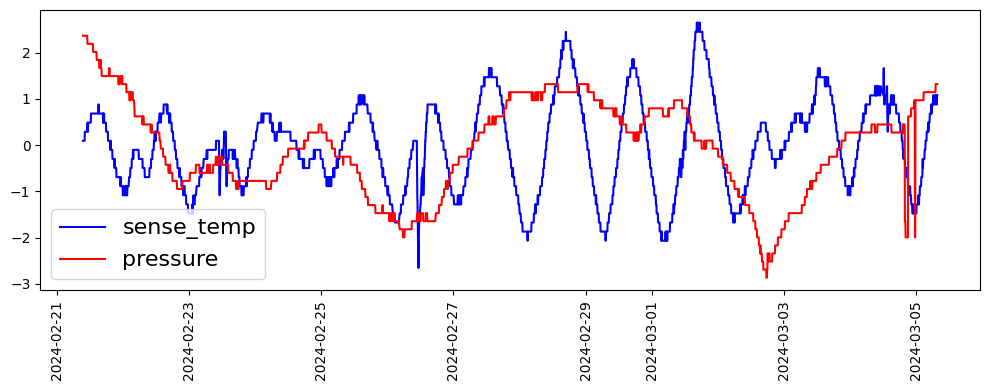

In [24]:
#Indoor temp with pressure
pressure_col = ["sense_temp", "pressure"]
df_temp_pre = df_trans[pressure_col]

plt.figure(figsize=(10, 4))
plt.plot(df_temp_pre["sense_temp"], color = "blue")
plt.plot(df_temp_pre["pressure"], color = "red")

plt.legend(["sense_temp", "pressure"], fontsize = 16)
plt.xticks(rotation=90)
plt.show()

In [25]:
#Cointegration
t_statistics, p_val, critical_p_val = coint(df_temp_pre["sense_temp"], df_temp_pre["pressure"])
print(f"t-statistics: {np.round(t_statistics, 2)} \np_value: {np.round(p_val, 2)} \ncritical p-values [10%, 5%, 1%]: {np.round(critical_p_val, 2)}")

t-statistics: -5.61 
p_value: 0.0 
critical p-values [10%, 5%, 1%]: [-3.9  -3.34 -3.05]


In [26]:
grangercausalitytests(df_temp_pre, 120, verbose = True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3710  , p=0.5425  , df_denom=3886, df_num=1
ssr based chi2 test:   chi2=0.3713  , p=0.5423  , df=1
likelihood ratio test: chi2=0.3713  , p=0.5423  , df=1
parameter F test:         F=0.3710  , p=0.5425  , df_denom=3886, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3809  , p=0.6833  , df_denom=3883, df_num=2
ssr based chi2 test:   chi2=0.7628  , p=0.6829  , df=2
likelihood ratio test: chi2=0.7627  , p=0.6829  , df=2
parameter F test:         F=0.3809  , p=0.6833  , df_denom=3883, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3916  , p=0.7590  , df_denom=3880, df_num=3
ssr based chi2 test:   chi2=1.1770  , p=0.7585  , df=3
likelihood ratio test: chi2=1.1768  , p=0.7586  , df=3
parameter F test:         F=0.3916  , p=0.7590  , df_denom=3880, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3868  , p=0.

/home/fraia/Arduino/Predictive Model/temppred.env/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


likelihood ratio test: chi2=8.8054  , p=0.9766  , df=19
parameter F test:         F=0.4593  , p=0.9776  , df_denom=3832, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=0.5555  , p=0.9430  , df_denom=3829, df_num=20
ssr based chi2 test:   chi2=11.2299 , p=0.9400  , df=20
likelihood ratio test: chi2=11.2137 , p=0.9405  , df=20
parameter F test:         F=0.5555  , p=0.9430  , df_denom=3829, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=0.5799  , p=0.9344  , df_denom=3826, df_num=21
ssr based chi2 test:   chi2=12.3152 , p=0.9307  , df=21
likelihood ratio test: chi2=12.2956 , p=0.9313  , df=21
parameter F test:         F=0.5799  , p=0.9344  , df_denom=3826, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=0.5635  , p=0.9483  , df_denom=3823, df_num=22
ssr based chi2 test:   chi2=12.5434 , p=0.9451  , df=22
likelihood ratio test: chi2=12.5231 , p=0.9456  , df=22
parameter F test:

{1: ({'ssr_ftest': (0.37100625897167067, 0.5424918872548574, 3886.0, 1),
   'ssr_chi2test': (0.371292676567377, 0.542300490491535, 1),
   'lrtest': (0.3712749535807234, 0.5423101281317884, 1),
   'params_ftest': (0.3710062589825715, 0.5424918872487541, 3886.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.38090645115632005, 0.6832673298300153, 3883.0, 2),
   'ssr_chi2test': (0.7627938614966635, 0.6829067691205201, 2),
   'lrtest': (0.7627190443236032, 0.6829323161753216, 2),
   'params_ftest': (0.3809064511585136, 0.6832673298285423, 3883.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.3916291274128944, 0.7590398040854598, 3880.0, 3),
   'ssr_chi2test': (1.1770070244231343, 0.7585240932476838, 3),
   'lrtest': (1.1768288579769433, 0.7585669031849037, 3),
   'params_ftest': (0.39162912741246125, 0.7590398040856672, 3880.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0

High cointegration and most likely not spurious correlation

`pressure` doesn't seem to have any significant granger causality on `sense_temp`.

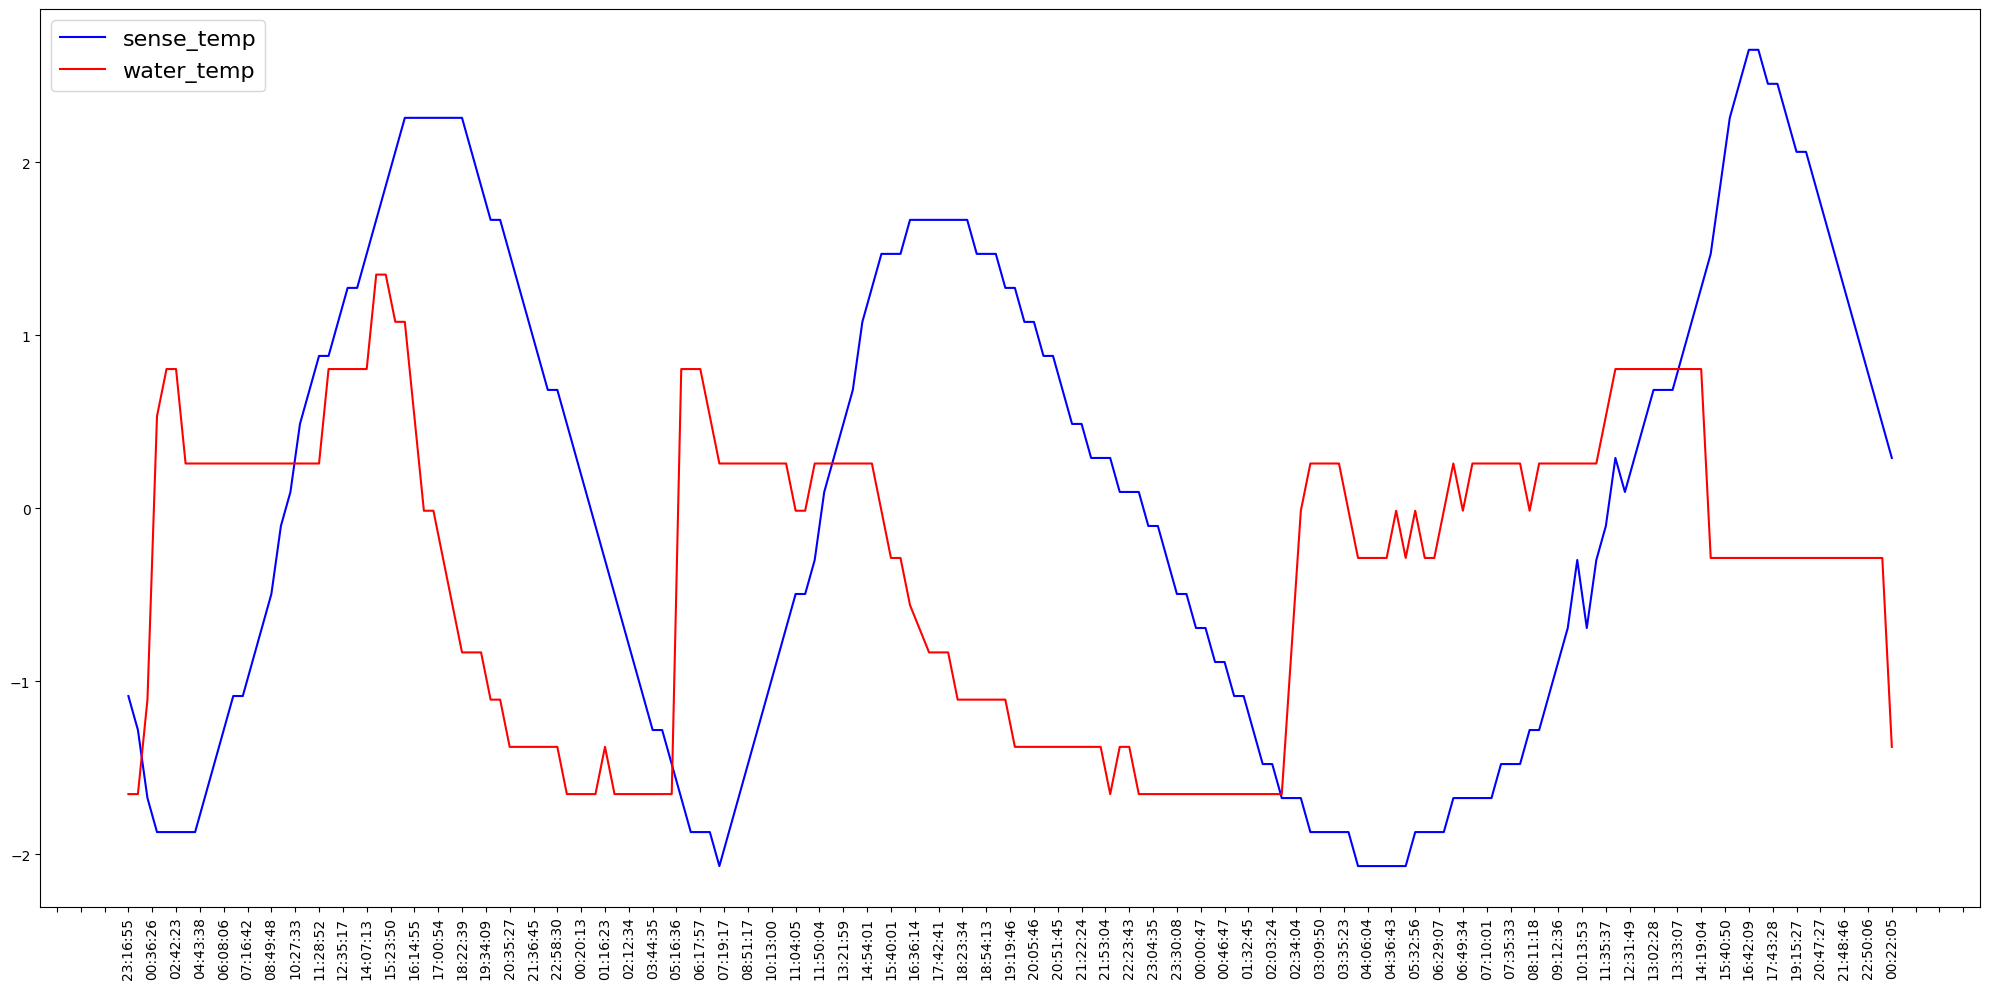

In [27]:
#Indoor temp with water temperature HVAC
water_col = ["sense_temp", "water_temp"]
df_temp_wat = df_trans[water_col]
df_temp_wat.index =pd.to_datetime(df_temp_wat.index)
df_temp_wat.index = df_temp_wat.index.time
df_temp_wat.index = df_temp_wat.index.astype(str)
df_temp_wat = df_temp_wat[::6]

plt.figure(figsize=(20, 10))
plt.plot(df_temp_wat["sense_temp"][304:490], color = "blue")
plt.plot(df_temp_wat["water_temp"][304:490], color = "red")

plt.legend(["sense_temp", "water_temp"], fontsize = 16)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins = 100))
plt.xticks(rotation=90)
plt.show()

In [28]:
len(df_temp_wat)

649

In [29]:
#Cointegration
t_statistics, p_val, critical_p_val = coint(df_temp_wat["sense_temp"], df_temp_wat["water_temp"])
print(f"t-statistics: {np.round(t_statistics, 2)} \np_value: {np.round(p_val, 2)} \ncritical p-values [10%, 5%, 1%]: {np.round(critical_p_val, 2)}")

t-statistics: -7.29 
p_value: 0.0 
critical p-values [10%, 5%, 1%]: [-3.91 -3.35 -3.05]


In [30]:
grangercausalitytests(df_temp_wat, 20, verbose = True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=111.3471, p=0.0000  , df_denom=645, df_num=1
ssr based chi2 test:   chi2=111.8650, p=0.0000  , df=1
likelihood ratio test: chi2=103.1940, p=0.0000  , df=1
parameter F test:         F=111.3471, p=0.0000  , df_denom=645, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=38.3774 , p=0.0000  , df_denom=642, df_num=2
ssr based chi2 test:   chi2=77.3526 , p=0.0000  , df=2
likelihood ratio test: chi2=73.0670 , p=0.0000  , df=2
parameter F test:         F=38.3774 , p=0.0000  , df_denom=642, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=18.1048 , p=0.0000  , df_denom=639, df_num=3
ssr based chi2 test:   chi2=54.9095 , p=0.0000  , df=3
likelihood ratio test: chi2=52.7002 , p=0.0000  , df=3
parameter F test:         F=18.1048 , p=0.0000  , df_denom=639, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=10.8349 , p=0.0000  

/home/fraia/Arduino/Predictive Model/temppred.env/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (111.34709254211877, 4.0239036226027905e-24, 645.0, 1),
   'ssr_chi2test': (111.86498599580302, 3.8249059519084787e-26, 1),
   'lrtest': (103.19404609933463, 3.038779712080174e-24, 1),
   'params_ftest': (111.34709254211795, 4.023903622604134e-24, 645.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (38.37738813637611, 1.8043687122696314e-16, 642.0, 2),
   'ssr_chi2test': (77.35255490415996, 1.5962691558399366e-17, 2),
   'lrtest': (73.06696107062226, 1.3605390106552742e-16, 2),
   'params_ftest': (38.37738813637583, 1.8043687122700544e-16, 642.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (18.10482579226668, 2.7558671959027863e-11, 639.0, 3),
   'ssr_chi2test': (54.909471651663274, 7.178391854587728e-12, 3),
   'lrtest': (52.700184639929375, 2.1240493189107575e-11, 3),
   'params_ftest': (18.10482579226664, 2.755867195902972e-11, 639.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0.

High cointegration and most likely not spurious correlation

`water_temp`has clearly a granger causality on `sense_temp` from the very beginning up to the 40th lag. Lags between 1 and 17 are have pvalues close to 0. However, the F-test starts going down drastically after the 10th lag. 

In [31]:
#df_cl.to_csv("data/home_data_cl.csv")

## Humidity

In [32]:
df_hum = pd.DataFrame(df_cl["sense_hum"])

#Is it stationary?
adf, p_value, usedlag_, nobs_, criticalvalues_, icbest_ = adfuller(df_hum)
print("p_value:", p_value, "\nIf above 0.05 data is not stationary") #stationary: mean and variance don't change over time

p_value: 0.4583476160705296 
If above 0.05 data is not stationary


Humidity data is likely not stationary (it's seasonal), meaning that the mean and variance change over time. In case of developing a univariate timeseries predictive model we should use SARIMA not just ARIMA (Autoregressive Integrated Moving Average)

Axes(0.125,0.11;0.352273x0.77)
Axes(0.547727,0.11;0.352273x0.77)


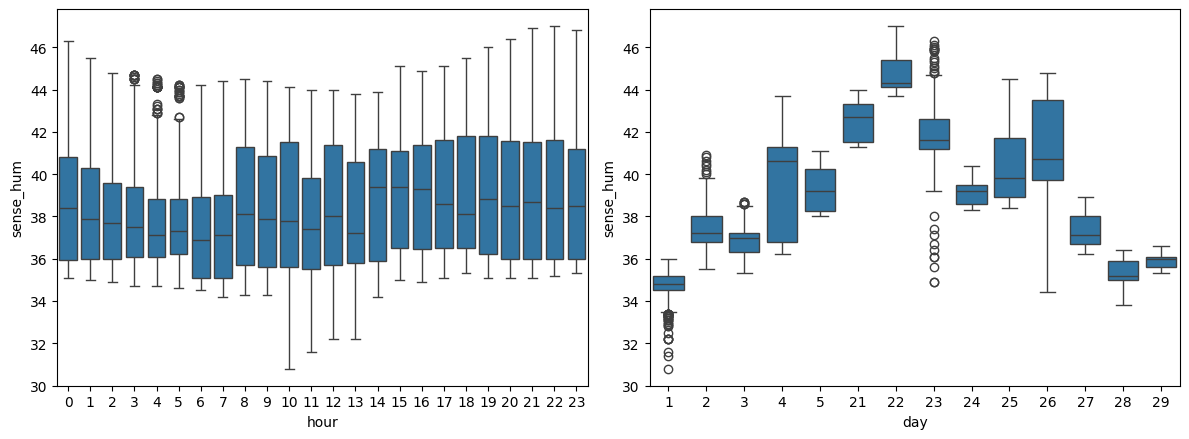

In [33]:
df_hum["hour"] = [d.hour for d in df_hum.index]
df_hum["day"] = [d.day for d in df_hum.index]

plt.rcParams["figure.figsize"] = [12.00, 4.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots(1,2)
print(sns.boxplot(x = "hour", y = "sense_hum", data=df_hum, ax=ax[0]))
print(sns.boxplot(x = "day", y = "sense_hum", data=df_hum, ax=ax[1]))
plt.show()

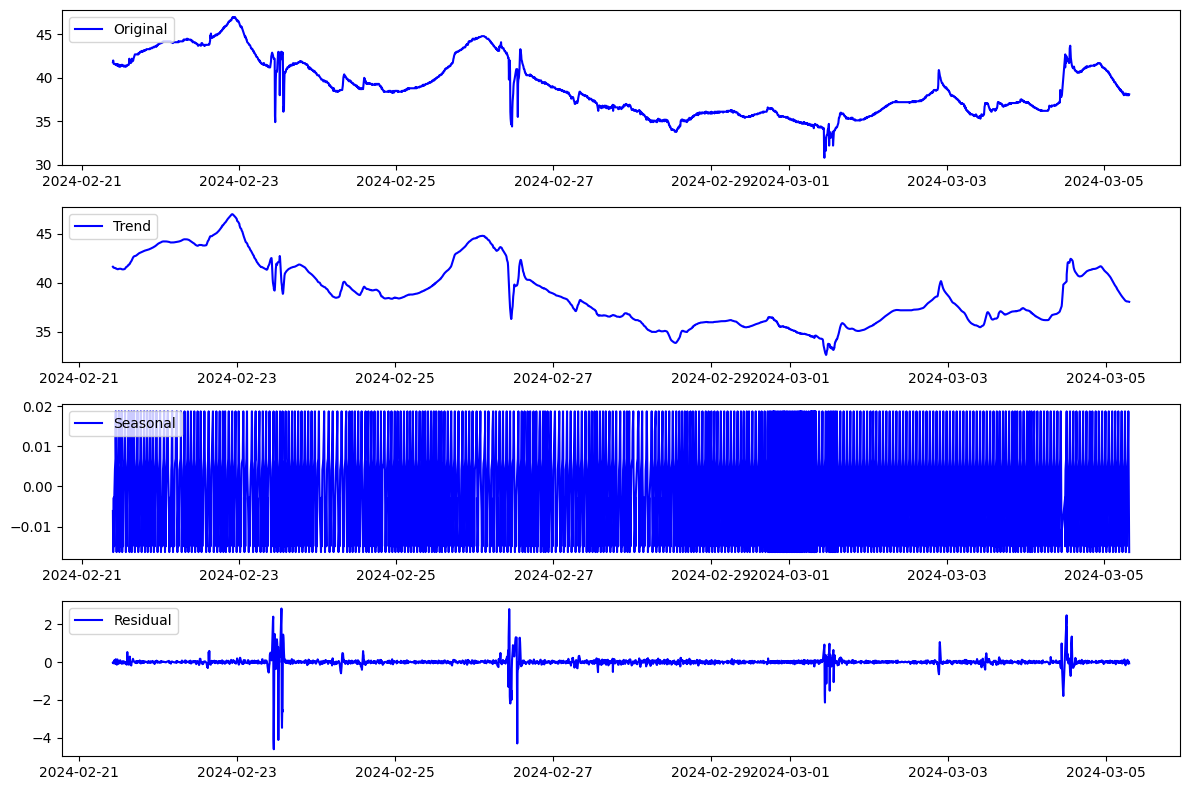

In [34]:
decompose = seasonal_decompose(df_hum["sense_hum"], model = "additive", period=12)

trend = decompose.trend
seasonal = decompose.seasonal #original minus the trend
residual = decompose.resid #whatever is remaining

plt.figure(figsize= (12, 8))
plt.subplot(411)
plt.plot(df_hum["sense_hum"], label = "Original", color = "blue")
plt.legend(loc = "upper left")
plt.subplot(412)
plt.plot(trend, label = "Trend", color = "blue")
plt.legend(loc = "upper left")
plt.subplot(413)
plt.plot(seasonal, label = "Seasonal", color = "blue")
plt.legend(loc = "upper left")
plt.subplot(414)
plt.plot(residual, label = "Residual", color = "blue")
plt.legend(loc = "upper left")

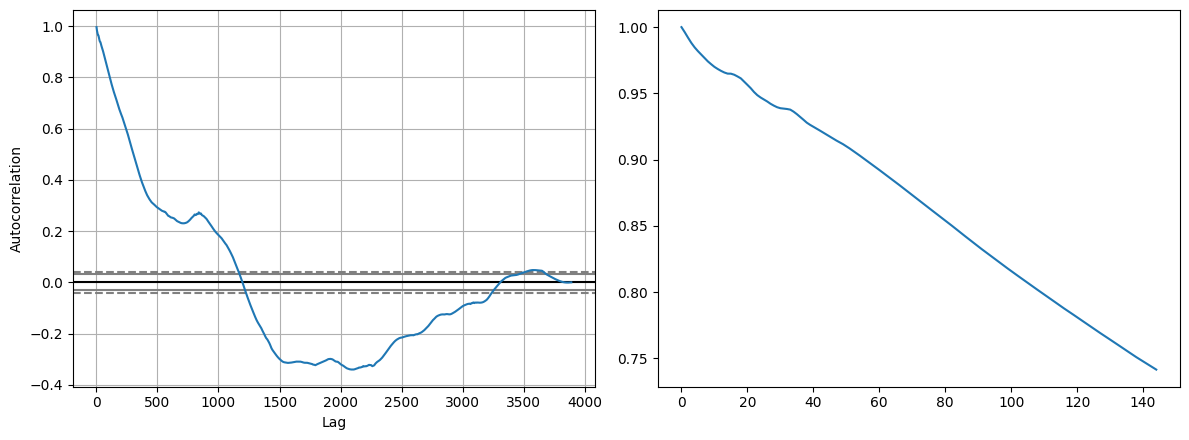

In [35]:
from pandas.plotting import autocorrelation_plot

fig, ax = plt.subplots(1, 2)
autocorrelation_plot(df_hum["sense_hum"], ax= ax[0])

#Autocorrelation
acf_144 = acf(df_hum.sense_hum, nlags=144)
ax[1].plot(acf_144)

Any lag below 600 is highly autocorrelated at a 99% confidence interval

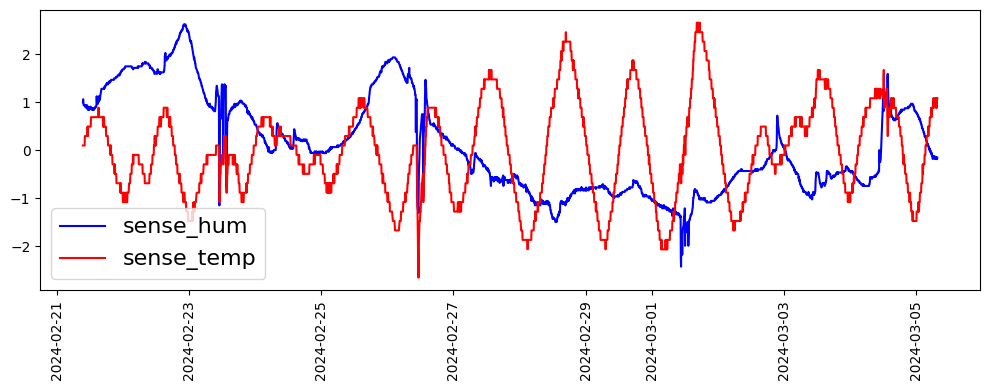

In [36]:
#Indoor temp with indoor humidity 
hum_temp = ["sense_hum", "sense_temp"]
df_temp_hum = df_trans[hum_temp]

plt.figure(figsize=(10, 4))
plt.plot(df_temp_hum["sense_hum"], color = "blue")
plt.plot(df_temp_hum["sense_temp"], color = "red")

plt.legend(["sense_hum", "sense_temp"], fontsize = 16)
plt.xticks(rotation=90)
plt.show()


In [37]:
#Cointegration
t_statistics, p_val, critical_p_val = coint(df_temp_hum["sense_hum"], df_temp_hum["sense_temp"])
print(f"t-statistics: {np.round(t_statistics, 2)} \np_value: {np.round(p_val, 2)} \ncritical p-values [10%, 5%, 1%]: {np.round(critical_p_val, 2)}")

t-statistics: -1.67 
p_value: 0.69 
critical p-values [10%, 5%, 1%]: [-3.9  -3.34 -3.05]


In [38]:
grangercausalitytests(df_temp_hum, 40, verbose = True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4290  , p=0.5125  , df_denom=3886, df_num=1
ssr based chi2 test:   chi2=0.4293  , p=0.5123  , df=1
likelihood ratio test: chi2=0.4293  , p=0.5124  , df=1
parameter F test:         F=0.4290  , p=0.5125  , df_denom=3886, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4184  , p=0.0892  , df_denom=3883, df_num=2
ssr based chi2 test:   chi2=4.8430  , p=0.0888  , df=2
likelihood ratio test: chi2=4.8400  , p=0.0889  , df=2
parameter F test:         F=2.4184  , p=0.0892  , df_denom=3883, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3718  , p=0.0685  , df_denom=3880, df_num=3
ssr based chi2 test:   chi2=7.1281  , p=0.0679  , df=3
likelihood ratio test: chi2=7.1216  , p=0.0681  , df=3
parameter F test:         F=2.3718  , p=0.0685  , df_denom=3880, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0046  , p=0.

/home/fraia/Arduino/Predictive Model/temppred.env/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=3.1705  , p=0.0000  , df_denom=3805, df_num=28
ssr based chi2 test:   chi2=90.1025 , p=0.0000  , df=28
likelihood ratio test: chi2=89.0675 , p=0.0000  , df=28
parameter F test:         F=3.1705  , p=0.0000  , df_denom=3805, df_num=28

Granger Causality
number of lags (no zero) 29
ssr based F test:         F=3.1161  , p=0.0000  , df_denom=3802, df_num=29
ssr based chi2 test:   chi2=91.7706 , p=0.0000  , df=29
likelihood ratio test: chi2=90.6969 , p=0.0000  , df=29
parameter F test:         F=3.1161  , p=0.0000  , df_denom=3802, df_num=29

Granger Causality
number of lags (no zero) 30
ssr based F test:         F=3.1120  , p=0.0000  , df_denom=3799, df_num=30
ssr based chi2 test:   chi2=94.8580 , p=0.0000  , df=30
likelihood ratio test: chi2=93.7112 , p=0.0000  , df=30
parameter F test:         F=3.1120  , p=0.0000  , df_denom=3799, df_num=30

Granger Causality
number of lags (no zero) 31
ssr based F test:         F=3.2027  , p=0.0000  , df_denom=3796, df_num=3

{1: ({'ssr_ftest': (0.42895266861888776, 0.5125420701947978, 3886.0, 1),
   'ssr_chi2test': (0.4292838209621344, 0.5123405757539348, 1),
   'lrtest': (0.42926012963653193, 0.5123522148146566, 1),
   'params_ftest': (0.4289526686113198, 0.5125420701986155, 3886.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.4183723525198344, 0.0892006087449117, 3883.0, 2),
   'ssr_chi2test': (4.842972807930526, 0.08878954219751084, 2),
   'lrtest': (4.839959057033411, 0.08892343783542553, 2),
   'params_ftest': (2.418372352518915, 0.08920060874499486, 3883.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.3717542121800776, 0.0684833939233538, 3880.0, 3),
   'ssr_chi2test': (7.128099450575227, 0.06792496953095768, 3),
   'lrtest': (7.121571566687635, 0.06812218077368974, 3),
   'params_ftest': (2.371754212180317, 0.06848339392332427, 3880.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 

No cointegration

After the 2th lag there is `sense_temp` grangarly causes `sense_hum`. From the 6th lag to the 35th all pvalues are closest to zero.

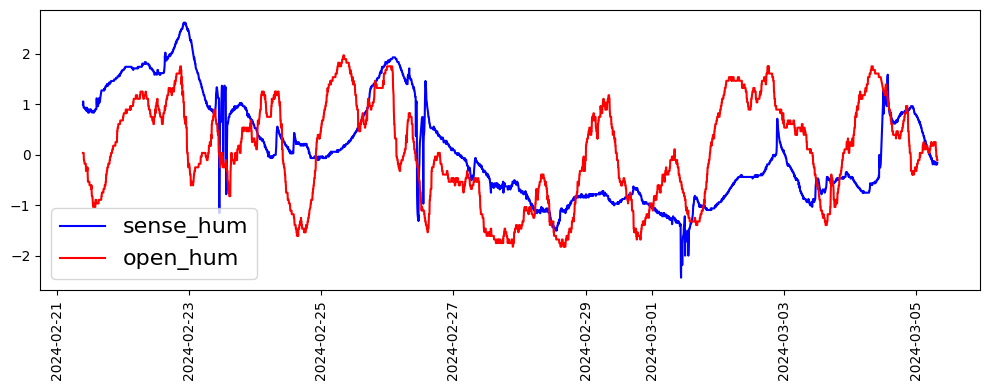

In [39]:
#Indoor temperature with outdoor humidity
hum_hum_col = ["sense_hum", "open_hum"]
df_hum_hum = df_trans[hum_hum_col]

plt.figure(figsize=(10, 4))
plt.plot(df_hum_hum["sense_hum"], color = "blue")
plt.plot(df_hum_hum["open_hum"], color = "red")

plt.legend(["sense_hum", "open_hum"], fontsize = 16)
plt.xticks(rotation=90)
plt.show()

In [40]:
#Cointergration
t_statistics, p_val, critical_p_val = coint(df_hum_hum["sense_hum"], df_hum_hum["open_hum"])
print(f"t-statistics: {np.round(t_statistics, 2)} \np_value: {np.round(p_val, 2)} \ncritical p-values [10%, 5%, 1%]: {np.round(critical_p_val, 2)}")

t-statistics: -2.29 
p_value: 0.38 
critical p-values [10%, 5%, 1%]: [-3.9  -3.34 -3.05]


In [41]:
grangercausalitytests(df_hum_hum, 40, verbose = True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8914  , p=0.0087  , df_denom=3886, df_num=1
ssr based chi2 test:   chi2=6.8967  , p=0.0086  , df=1
likelihood ratio test: chi2=6.8906  , p=0.0087  , df=1
parameter F test:         F=6.8914  , p=0.0087  , df_denom=3886, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.9668  , p=0.0026  , df_denom=3883, df_num=2
ssr based chi2 test:   chi2=11.9489 , p=0.0025  , df=2
likelihood ratio test: chi2=11.9306 , p=0.0026  , df=2
parameter F test:         F=5.9668  , p=0.0026  , df_denom=3883, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.0017  , p=0.0074  , df_denom=3880, df_num=3
ssr based chi2 test:   chi2=12.0269 , p=0.0073  , df=3
likelihood ratio test: chi2=12.0083 , p=0.0074  , df=3
parameter F test:         F=4.0017  , p=0.0074  , df_denom=3880, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2946  , p=0.

/home/fraia/Arduino/Predictive Model/temppred.env/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=1.8966  , p=0.0060  , df_denom=3820, df_num=23
ssr based chi2 test:   chi2=44.1587 , p=0.0050  , df=23
likelihood ratio test: chi2=43.9085 , p=0.0054  , df=23
parameter F test:         F=1.8966  , p=0.0060  , df_denom=3820, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=1.7973  , p=0.0099  , df_denom=3817, df_num=24
ssr based chi2 test:   chi2=43.6897 , p=0.0083  , df=24
likelihood ratio test: chi2=43.4447 , p=0.0088  , df=24
parameter F test:         F=1.7973  , p=0.0099  , df_denom=3817, df_num=24

Granger Causality
number of lags (no zero) 25
ssr based F test:         F=1.8781  , p=0.0052  , df_denom=3814, df_num=25
ssr based chi2 test:   chi2=47.5807 , p=0.0042  , df=25
likelihood ratio test: chi2=47.2902 , p=0.0045  , df=25
parameter F test:         F=1.8781  , p=0.0052  , df_denom=3814, df_num=25

Granger Causality
number of lags (no zero) 26
ssr based F test:         F=1.8061  , p=0.0074  , df_denom=3811, df_num=2

{1: ({'ssr_ftest': (6.891375671286237, 0.008695190075424998, 3886.0, 1),
   'ssr_chi2test': (6.896695827491554, 0.008635520642002436, 1),
   'lrtest': (6.89058779782863, 0.00866507705830162, 1),
   'params_ftest': (6.891375671283437, 0.008695190075437014, 3886.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (5.966758081176644, 0.0025860902822798532, 3883.0, 2),
   'ssr_chi2test': (11.948882523623377, 0.002542922517827995, 2),
   'lrtest': (11.930558971638675, 0.0025663272550698448, 2),
   'params_ftest': (5.966758081177375, 0.0025860902822778917, 3883.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (4.001734049021707, 0.007423651573312879, 3880.0, 3),
   'ssr_chi2test': (12.026861016918074, 0.007291710139926509, 3),
   'lrtest': (12.008293006962049, 0.007354806089590264, 3),
   'params_ftest': (4.001734049025491, 0.007423651573272177, 3880.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],


No cointegration

Between the 1st and 2nd lag there is granger causality from `open_hum` on `sense_hum`, however in the following lags pvalues increase above 0.05 up till the 23rd lag. From the 23rd lag to the 40th lag all pvalues are nearly zero.

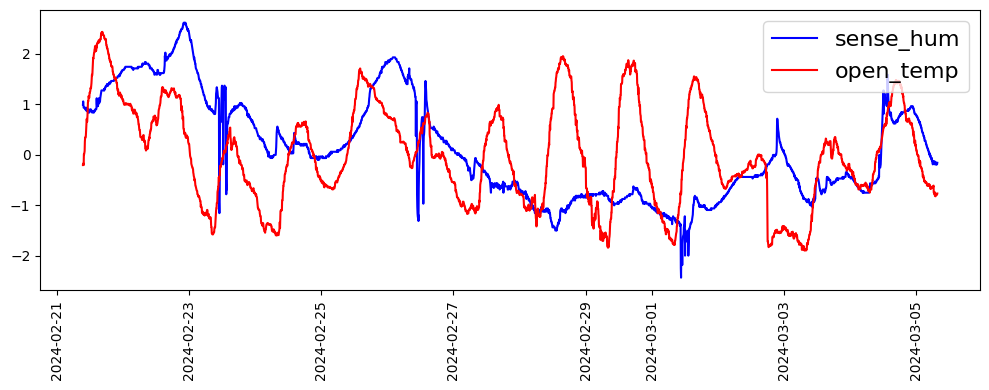

In [42]:
hum_optemp_col = ["sense_hum", "open_temp"]
df_hum_optemp = df_trans[hum_optemp_col]

plt.figure(figsize=(10, 4))
plt.plot(df_hum_optemp["sense_hum"], color = "blue")
plt.plot(df_hum_optemp["open_temp"], color = "red")

plt.legend(["sense_hum", "open_temp"], fontsize = 16)
plt.xticks(rotation=90)
plt.show()

In [43]:
#Cointegration
t_statistics, p_val, critical_p_val = coint(df_hum_optemp["sense_hum"], df_hum_optemp["open_temp"])
print(f"t-statistics: {np.round(t_statistics, 2)} \np_value: {np.round(p_val, 2)} \ncritical p-values [10%, 5%, 1%]: {np.round(critical_p_val, 2)}")

t-statistics: -1.87 
p_value: 0.59 
critical p-values [10%, 5%, 1%]: [-3.9  -3.34 -3.05]


In [44]:
grangercausalitytests(df_hum_optemp, 40, verbose = True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.3336  , p=0.0023  , df_denom=3886, df_num=1
ssr based chi2 test:   chi2=9.3408  , p=0.0022  , df=1
likelihood ratio test: chi2=9.3296  , p=0.0023  , df=1
parameter F test:         F=9.3336  , p=0.0023  , df_denom=3886, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.2737  , p=0.0019  , df_denom=3883, df_num=2
ssr based chi2 test:   chi2=12.5636 , p=0.0019  , df=2
likelihood ratio test: chi2=12.5433 , p=0.0019  , df=2
parameter F test:         F=6.2737  , p=0.0019  , df_denom=3883, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2657  , p=0.0051  , df_denom=3880, df_num=3
ssr based chi2 test:   chi2=12.8203 , p=0.0050  , df=3
likelihood ratio test: chi2=12.7992 , p=0.0051  , df=3
parameter F test:         F=4.2657  , p=0.0051  , df_denom=3880, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.3030  , p=0.

/home/fraia/Arduino/Predictive Model/temppred.env/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=1.5033  , p=0.0516  , df_denom=3814, df_num=25
ssr based chi2 test:   chi2=38.0859 , p=0.0454  , df=25
likelihood ratio test: chi2=37.8994 , p=0.0473  , df=25
parameter F test:         F=1.5033  , p=0.0516  , df_denom=3814, df_num=25

Granger Causality
number of lags (no zero) 26
ssr based F test:         F=1.4736  , p=0.0575  , df_denom=3811, df_num=26
ssr based chi2 test:   chi2=38.8470 , p=0.0504  , df=26
likelihood ratio test: chi2=38.6531 , p=0.0526  , df=26
parameter F test:         F=1.4736  , p=0.0575  , df_denom=3811, df_num=26

Granger Causality
number of lags (no zero) 27
ssr based F test:         F=1.4033  , p=0.0807  , df_denom=3808, df_num=27
ssr based chi2 test:   chi2=38.4366 , p=0.0712  , df=27
likelihood ratio test: chi2=38.2466 , p=0.0740  , df=27
parameter F test:         F=1.4033  , p=0.0807  , df_denom=3808, df_num=27

Granger Causality
number of lags (no zero) 28
ssr based F test:         F=1.5498  , p=0.0326  , df_denom=3805, df_num=2

{1: ({'ssr_ftest': (9.333641379122074, 0.00226511284836396, 3886.0, 1),
   'ssr_chi2test': (9.340846969481666, 0.002241019286950537, 1),
   'lrtest': (9.329647179984022, 0.002254757637072248, 1),
   'params_ftest': (9.333641379116171, 0.002265112848370418, 3886.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (6.273697639604165, 0.0019044098367410045, 3883.0, 2),
   'ssr_chi2test': (12.563552110626315, 0.0018700762840965562, 2),
   'lrtest': (12.543297013973643, 0.0018891118008944065, 2),
   'params_ftest': (6.2736976396060555, 0.0019044098367373933, 3883.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (4.265728934711439, 0.0051426773423633755, 3880.0, 3),
   'ssr_chi2test': (12.820274512286106, 0.005041840567066977, 3),
   'lrtest': (12.799178688797838, 0.005091646534144536, 3),
   'params_ftest': (4.265728934712352, 0.005142677342357137, 3880.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0

No cointegration

There is granger causality from `open_temp` on `sense_hum` right after the first lag. All pvalues are close to zero from the 14th lag to the 40th.

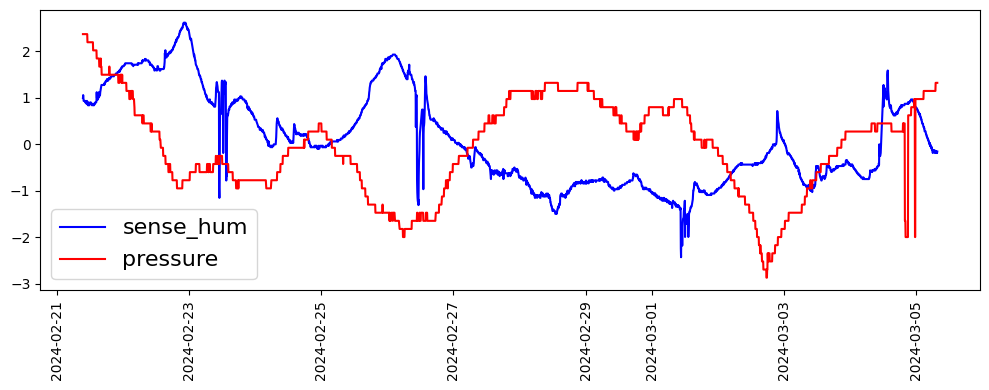

In [45]:
hum_pres_col = ["sense_hum", "pressure"]
df_hum_pres = df_trans[hum_pres_col]

plt.figure(figsize=(10, 4))
plt.plot(df_hum_pres["sense_hum"], color = "blue")
plt.plot(df_hum_pres["pressure"], color = "red")

plt.legend(["sense_hum", "pressure"], fontsize = 16)
plt.xticks(rotation=90)
plt.show()

In [46]:
#Cointegration
t_statistics, p_val, critical_p_val = coint(df_hum_pres["sense_hum"], df_hum_pres["pressure"])
print(f"t-statistics: {np.round(t_statistics, 2)} \np_value: {np.round(p_val, 2)} \ncritical p-values [10%, 5%, 1%]: {np.round(critical_p_val, 2)}")

t-statistics: -1.93 
p_value: 0.56 
critical p-values [10%, 5%, 1%]: [-3.9  -3.34 -3.05]


In [47]:
grangercausalitytests(df_hum_pres, 40, verbose = True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4813  , p=0.4879  , df_denom=3886, df_num=1
ssr based chi2 test:   chi2=0.4816  , p=0.4877  , df=1
likelihood ratio test: chi2=0.4816  , p=0.4877  , df=1
parameter F test:         F=0.4813  , p=0.4879  , df_denom=3886, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5004  , p=0.6063  , df_denom=3883, df_num=2
ssr based chi2 test:   chi2=1.0022  , p=0.6059  , df=2
likelihood ratio test: chi2=1.0021  , p=0.6059  , df=2
parameter F test:         F=0.5004  , p=0.6063  , df_denom=3883, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4823  , p=0.6946  , df_denom=3880, df_num=3
ssr based chi2 test:   chi2=1.4494  , p=0.6940  , df=3
likelihood ratio test: chi2=1.4491  , p=0.6941  , df=3
parameter F test:         F=0.4823  , p=0.6946  , df_denom=3880, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3508  , p=0.

/home/fraia/Arduino/Predictive Model/temppred.env/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=0.7030  , p=0.8752  , df_denom=3805, df_num=28
ssr based chi2 test:   chi2=19.9785 , p=0.8652  , df=28
likelihood ratio test: chi2=19.9270 , p=0.8671  , df=28
parameter F test:         F=0.7030  , p=0.8752  , df_denom=3805, df_num=28

Granger Causality
number of lags (no zero) 29
ssr based F test:         F=0.6857  , p=0.8959  , df_denom=3802, df_num=29
ssr based chi2 test:   chi2=20.1951 , p=0.8868  , df=29
likelihood ratio test: chi2=20.1425 , p=0.8884  , df=29
parameter F test:         F=0.6857  , p=0.8959  , df_denom=3802, df_num=29

Granger Causality
number of lags (no zero) 30
ssr based F test:         F=0.6922  , p=0.8945  , df_denom=3799, df_num=30
ssr based chi2 test:   chi2=21.0993 , p=0.8848  , df=30
likelihood ratio test: chi2=21.0419 , p=0.8866  , df=30
parameter F test:         F=0.6922  , p=0.8945  , df_denom=3799, df_num=30

Granger Causality
number of lags (no zero) 31
ssr based F test:         F=0.7091  , p=0.8829  , df_denom=3796, df_num=3

{1: ({'ssr_ftest': (0.4812741554133678, 0.4878872076557045, 3886.0, 1),
   'ssr_chi2test': (0.48164570005213264, 0.4876778262835193, 1),
   'lrtest': (0.4816158770227048, 0.4876913010083521, 1),
   'params_ftest': (0.4812741554042749, 0.48788720765980076, 3886.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.5004494895802497, 0.6062971893577076, 3883.0, 2),
   'ssr_chi2test': (1.002187800920943, 0.6058675383052153, 2),
   'lrtest': (1.0020586589635059, 0.6059066610282202, 2),
   'params_ftest': (0.5004494895797591, 0.6062971893579691, 3883.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.4822594557937364, 0.6946265642799796, 3880.0, 3),
   'ssr_chi2test': (1.449388534538856, 0.6939997013962205, 3),
   'lrtest': (1.4491183769569034, 0.6940625648168646, 3),
   'params_ftest': (0.48225945579428603, 0.6946265642795784, 3880.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0

No cointegration

There is a clear granger causality of `pressure`on `sense_hum`after the 6th lag. From the 15th lag till the 40th all pvalues are close to zero.

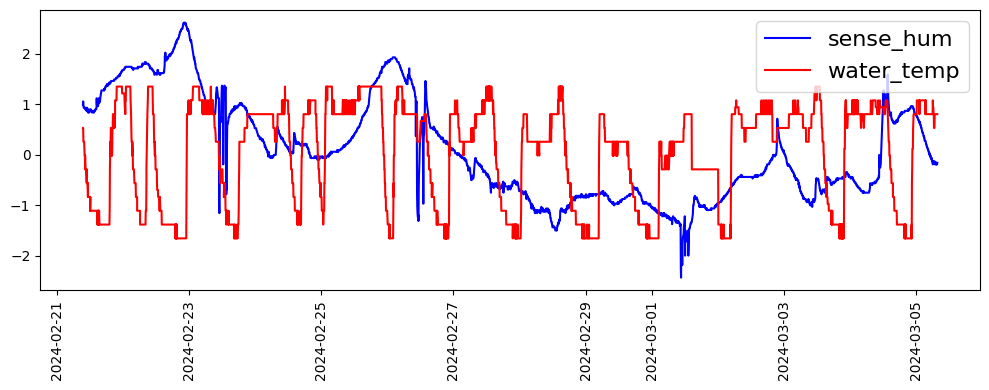

In [48]:
hum_wt_col = ["sense_hum", "water_temp"]
df_hum_wt = df_trans[hum_wt_col]

plt.figure(figsize=(10, 4))
plt.plot(df_hum_wt["sense_hum"], color = "blue")
plt.plot(df_hum_wt["water_temp"], color = "red")

plt.legend(["sense_hum", "water_temp"], fontsize = 16)
plt.xticks(rotation=90)
plt.show()

In [49]:
#Cointegration
t_statistics, p_val, critical_p_val = coint(df_hum_wt["sense_hum"], df_hum_wt["water_temp"])
print(f"t-statistics: {np.round(t_statistics, 2)} \np_value: {np.round(p_val, 2)} \ncritical p-values [10%, 5%, 1%]: {np.round(critical_p_val, 2)}")

t-statistics: -1.69 
p_value: 0.68 
critical p-values [10%, 5%, 1%]: [-3.9  -3.34 -3.05]


In [50]:
grangercausalitytests(df_hum_wt, 40, verbose = True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8121  , p=0.3676  , df_denom=3886, df_num=1
ssr based chi2 test:   chi2=0.8127  , p=0.3673  , df=1
likelihood ratio test: chi2=0.8126  , p=0.3674  , df=1
parameter F test:         F=0.8121  , p=0.3676  , df_denom=3886, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6635  , p=0.5151  , df_denom=3883, df_num=2
ssr based chi2 test:   chi2=1.3287  , p=0.5146  , df=2
likelihood ratio test: chi2=1.3285  , p=0.5147  , df=2
parameter F test:         F=0.6635  , p=0.5151  , df_denom=3883, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1873  , p=0.0874  , df_denom=3880, df_num=3
ssr based chi2 test:   chi2=6.5739  , p=0.0868  , df=3
likelihood ratio test: chi2=6.5683  , p=0.0870  , df=3
parameter F test:         F=2.1873  , p=0.0874  , df_denom=3880, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7916  , p=0.

/home/fraia/Arduino/Predictive Model/temppred.env/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=0.8857  , p=0.6015  , df_denom=3832, df_num=19
ssr based chi2 test:   chi2=16.9989 , p=0.5899  , df=19
likelihood ratio test: chi2=16.9617 , p=0.5925  , df=19
parameter F test:         F=0.8857  , p=0.6015  , df_denom=3832, df_num=19

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=0.8522  , p=0.6499  , df_denom=3829, df_num=20
ssr based chi2 test:   chi2=17.2269 , p=0.6382  , df=20
likelihood ratio test: chi2=17.1887 , p=0.6407  , df=20
parameter F test:         F=0.8522  , p=0.6499  , df_denom=3829, df_num=20

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=0.9417  , p=0.5356  , df_denom=3826, df_num=21
ssr based chi2 test:   chi2=19.9986 , p=0.5213  , df=21
likelihood ratio test: chi2=19.9471 , p=0.5246  , df=21
parameter F test:         F=0.9417  , p=0.5356  , df_denom=3826, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=1.1255  , p=0.3094  , df_denom=3823, df_num=2

{1: ({'ssr_ftest': (0.8120542220932309, 0.3675694598798338, 3886.0, 1),
   'ssr_chi2test': (0.8126811296244403, 0.36732875933453657, 1),
   'lrtest': (0.8125962287922448, 0.36735378646291683, 1),
   'params_ftest': (0.8120542220879534, 0.3675694598812337, 3886.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.6634973197952378, 0.5151052798710083, 3883.0, 2),
   'ssr_chi2test': (1.3287033630511897, 0.5146070488378149, 2),
   'lrtest': (1.3284763761039358, 0.5146654566937332, 2),
   'params_ftest': (0.6634973197955691, 0.515105279870786, 3883.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.187339909925465, 0.08742908398413013, 3880.0, 3),
   'ssr_chi2test': (6.573858425165167, 0.08679477961590124, 3),
   'lrtest': (6.568305691576825, 0.08700727186979013, 3),
   'params_ftest': (2.187339909925861, 0.08742908398405504, 3880.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0

No cointegration

There doesn't seem to be any granger causality by `water_temp` on `sense_hum`. 

### open_temp & water_temp

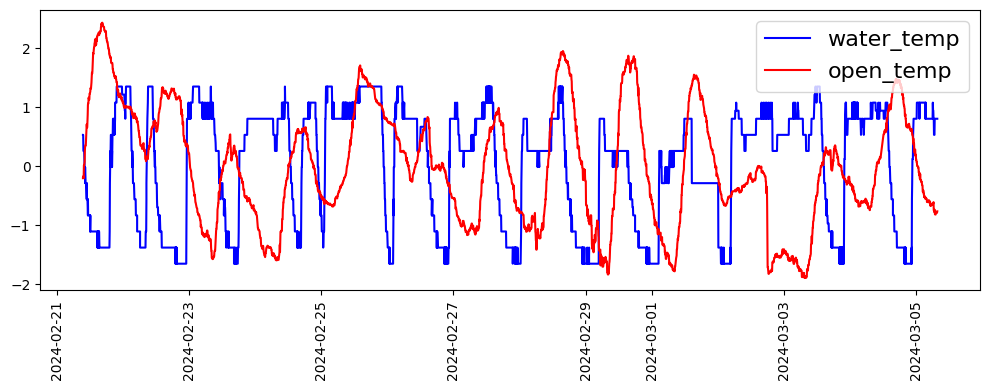

In [51]:
opt_wt_col = ["water_temp", "open_temp"]
df_opt_wt = df_trans[opt_wt_col]

plt.figure(figsize=(10, 4))
plt.plot(df_opt_wt["water_temp"], color = "blue")
plt.plot(df_opt_wt["open_temp"], color = "red")

plt.legend(["water_temp", "open_temp"], fontsize = 16)
plt.xticks(rotation=90)
plt.show()

In [52]:
#Cointegration
t_statistics, p_val, critical_p_val = coint(df_opt_wt["open_temp"], df_opt_wt["water_temp"])
print(f"t-statistics: {np.round(t_statistics, 2)} \np_value: {np.round(p_val, 2)} \ncritical p-values [10%, 5%, 1%]: {np.round(critical_p_val, 2)}")

t-statistics: -5.26 
p_value: 0.0 
critical p-values [10%, 5%, 1%]: [-3.9  -3.34 -3.05]


In [53]:
grangercausalitytests(df_opt_wt, 40, verbose = True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1726  , p=0.0025  , df_denom=3886, df_num=1
ssr based chi2 test:   chi2=9.1797  , p=0.0024  , df=1
likelihood ratio test: chi2=9.1689  , p=0.0025  , df=1
parameter F test:         F=9.1726  , p=0.0025  , df_denom=3886, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1004  , p=0.0023  , df_denom=3883, df_num=2
ssr based chi2 test:   chi2=12.2166 , p=0.0022  , df=2
likelihood ratio test: chi2=12.1974 , p=0.0022  , df=2
parameter F test:         F=6.1004  , p=0.0023  , df_denom=3883, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4612  , p=0.0157  , df_denom=3880, df_num=3
ssr based chi2 test:   chi2=10.4022 , p=0.0154  , df=3
likelihood ratio test: chi2=10.3883 , p=0.0155  , df=3
parameter F test:         F=3.4612  , p=0.0157  , df_denom=3880, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4203  , p=0.

/home/fraia/Arduino/Predictive Model/temppred.env/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=1.1378  , p=0.2989  , df_denom=3826, df_num=21
ssr based chi2 test:   chi2=24.1629 , p=0.2852  , df=21
likelihood ratio test: chi2=24.0878 , p=0.2888  , df=21
parameter F test:         F=1.1378  , p=0.2989  , df_denom=3826, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=1.1784  , p=0.2558  , df_denom=3823, df_num=22
ssr based chi2 test:   chi2=26.2308 , p=0.2419  , df=22
likelihood ratio test: chi2=26.1423 , p=0.2456  , df=22
parameter F test:         F=1.1784  , p=0.2558  , df_denom=3823, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=1.2046  , p=0.2281  , df_denom=3820, df_num=23
ssr based chi2 test:   chi2=28.0466 , p=0.2140  , df=23
likelihood ratio test: chi2=27.9454 , p=0.2179  , df=23
parameter F test:         F=1.2046  , p=0.2281  , df_denom=3820, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=1.1465  , p=0.2818  , df_denom=3817, df_num=2

{1: ({'ssr_ftest': (9.17259372568978, 0.002472805826843382, 3886.0, 1),
   'ssr_chi2test': (9.179674986929374, 0.0024471747636941577, 1),
   'lrtest': (9.168858059136255, 0.0024616812529420816, 1),
   'params_ftest': (9.17259372568749, 0.002472805826846591, 3886.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (6.100427660807149, 0.00226345346664396, 3883.0, 2),
   'ssr_chi2test': (12.216565925942929, 0.0022243668559737886, 2),
   'lrtest': (12.19741307249933, 0.0022457706646001607, 2),
   'params_ftest': (6.100427660812329, 0.0022634534666316065, 3883.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (3.461157544638854, 0.015662440702265426, 3880.0, 3),
   'ssr_chi2test': (10.402205703101462, 0.015439180398329566, 3),
   'lrtest': (10.388311540515133, 0.015538003631891738, 3),
   'params_ftest': (3.461157544636336, 0.01566244070231517, 3880.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
 

High cointegration and most likely not a spurious correlation 

No granger causality found except in the first lag?